<img src="./Logo_UNSAM.png" align="right" width="150" />

#### Procesamiento Digital de Señales
# Trabajo Práctico Nº5
#### Lucas Marú

# Enunciado

## Ancho de banda de señales reales
En el repositorio PDStestbench encontrará tres tipos de señales registradas:

* **Electrocardiograma (ECG).** En el archivo ECG_TP4.mat encontrará un registro electrocardiográfico (ECG) registrado durante una prueba de esfuerzo, junto con una serie de variables descriptas más abajo.
* **Pletismografía (PPG).** El archivo PPG.csv contiene una señal registrada en reposo de un estudiante de la materia que ha donado su registro para esta actividad.
* **Audio.** Tres registros en los que el profesor pronuncia una frase, y otros dos en los que se silba una melodía muy conocida.

Los detalles de cómo acceder a dichos registros los pueden encontrar en lectura_sigs.py

Se pide:

1) Realizar la estimación de la densidad espectral de potencia (PSD) de cada señal mediante alguno de los métodos vistos en clase (Periodograma ventaneado, Welch, Blackman-Tukey).

2) Realice una estimación del ancho de banda de cada señal y presente los resultados en un tabla para facilitar la comparación.


# Introducción

El objetivo de esta práctica es estimar la **densidad espectral de potencia (PSD)** de distintas señales reales utilizando métodos clásicos de análisis espectral, como **Welch** y **Blackman-Tukey**, y a partir de ella determinar el **ancho de banda efectivo** de cada señal.

La PSD describe cómo se distribuye la potencia de una señal en el dominio de la frecuencia. En señales de energía finita, su integral equivale a la potencia total según el **teorema de Parseval**. A través de la PSD, es posible estimar el ancho de banda como la frecuencia hasta la cual se acumula un cierto porcentaje (por ejemplo, el 95%) de la potencia total.

Se analizarán tres señales registradas:
- Un electrocardiograma (ECG),
- Una señal de pletismografía (PPG),
- Y un registro de audio.

El análisis incluirá estimación espectral, visualización y comparación del ancho de banda entre métodos y señales.


## Consigna 1
Se estimó la PSD de cada señal con el método de Welch (implementación de scipy) y el método de Blackman-Tukey (implementación manual). Se muestra el código utilizado para Blackman-Tukey:

In [4]:
#%% Función Blackman-Tukey

import numpy as np
from scipy import signal as sig

import matplotlib.pyplot as plt
   
import scipy.io as sio

def blackman_tukey(x, fs, M=None):
    x = x.flatten().astype(np.float64)
    N = len(x)
    
    if M is None:
        M = N // 5
    
    r_len = 2 * M - 1
    xx = x[:r_len]
    
    r = np.correlate(xx, xx, mode='same') / r_len
    w = sig.windows.blackman(r_len)
    r_win = r * w

    PSD = np.abs(np.fft.fft(r_win, n=N))
    PSD_db = 10 * np.log10(np.maximum(PSD, 1e-12))  # para evitar log(0)
    
    f = np.fft.fftfreq(N, d=1/fs)
    pos = f >= 0  # máscara para parte positiva

    return f[pos], PSD[pos], PSD_db[pos]

#### Electrocardiograma (ECG):
En el método de Welch, se dividió la señal en 20 bloques. Como se cuenta con 30.000 muestras, esto deja 1.500 muestras por segmento. Esta elección permite disponer de una buena cantidad de bloques, lo que ayuda a reducir la varianza de la estimación, sin comprometer demasiado la resolución espectral, ya que cada segmento conserva una cantidad significativa de muestras.

Para Blackman-Tukey, se utilizó una ventana del 20% del total de muestras, valor teóricamente asociado a un buen compromiso entre resolución y varianza: ventanas más cortas aumentan la varianza, mientras que ventanas más largas amplían el sesgo.

Finalmente, se decidió normalizar los espectros en amplitud respecto al valor máximo (colocando el pico en 0 dB), en lugar de normalizar en potencia (1 watt). Esto se debe a que las señales tienen anchos de banda muy disímiles, y mantener constante la potencia total distorsionaría la escala relativa entre espectros. Esta forma de normalización fue aplicada de manera uniforme en todo el experimento, favoreciendo la comparación visual y cuantitativa entre señales.

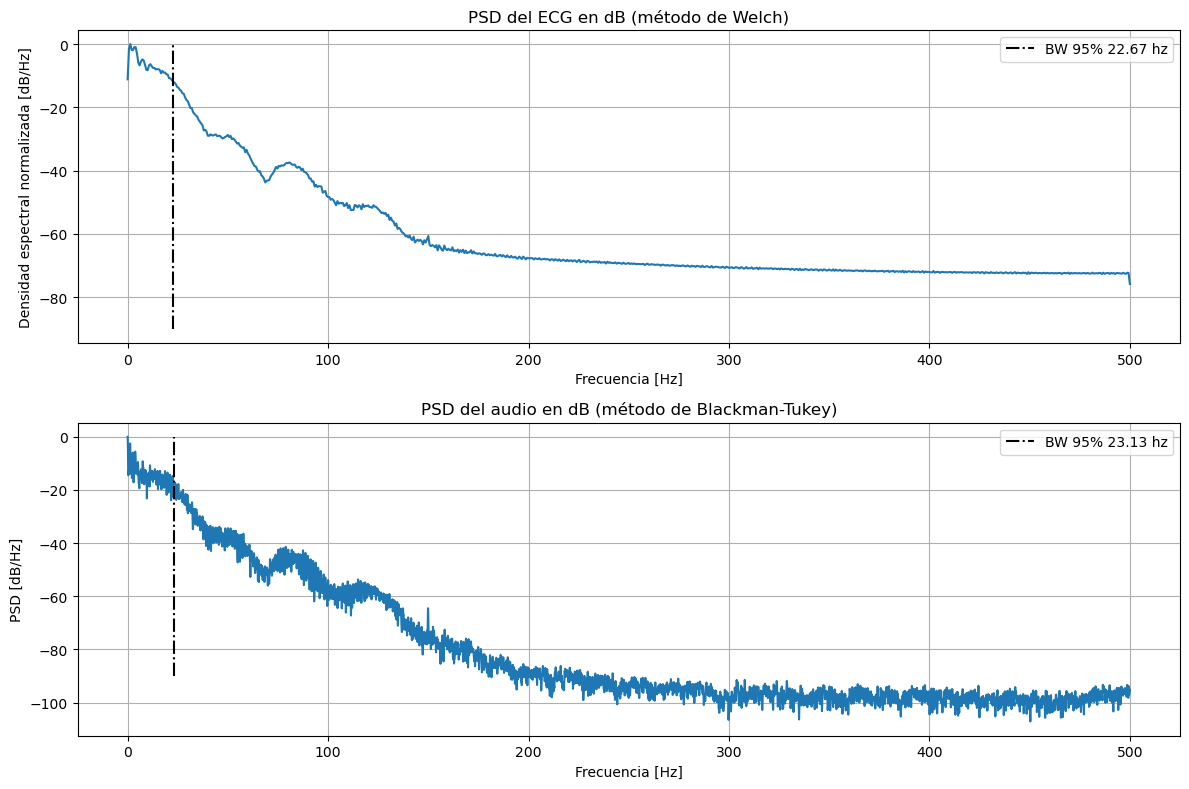

In [16]:
##Lectura##
fs_ecg = 1000 # Hz, la frecuencia de muestreo a la que fue sampleada la señal del archivo
ecg_one_lead = np.load('ecg_sin_ruido.npy')
N_ecg = len(ecg_one_lead)

##Welch##
nperseg = N_ecg // 20  #cantidad de segmentos
noverlap = nperseg//2 #solapamiento
f_ecg, PSD_ecg = sig.welch(ecg_one_lead, fs_ecg, window='hamming',
                    nperseg=nperseg, noverlap=noverlap, detrend='constant')
PSD_ecg_db = 10 * np.log10(PSD_ecg) #Paso a dB
PSD_ecg_db_norm= PSD_ecg_db - np.max(PSD_ecg_db)#Normalizo respecto al máximo (pico en 0 dB)

##Blackman-Tukey##
f_ecg_bt, PSD_bt, PSD_db_bt = blackman_tukey(ecg_one_lead, fs=fs_ecg, M=N_ecg//5) #Blackman-Tukey
PSD_db_bt_norm = PSD_db_bt - np.max(PSD_db_bt) #Normalizo respecto al máximo (pico en 0 dB)

##Estimación ancho de banda Welch##
porcentaje = 0.95
pot_total_welch =np.sum(PSD_ecg)
pot_acumulada_welch = np.cumsum(PSD_ecg) / pot_total_welch  # ahora ya es proporción
i = np.argmax(pot_acumulada_welch >= porcentaje)  # primer índice que supera el %
frec_buscada_welch = f_ecg[i]

##Estimación ancho de banda B-T##
pot_total_bt = np.sum(PSD_bt)
pot_acumulada_bt = np.cumsum(PSD_bt) / pot_total_bt  # ahora ya es proporción
i = np.argmax(pot_acumulada_bt >= porcentaje)  # primer índice que supera el %
frec_buscada_bt = f_ecg_bt[i]

#Visualización##
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(f_ecg, PSD_ecg_db_norm)
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Densidad espectral normalizada [dB/Hz]')
plt.title('PSD del ECG en dB (método de Welch)')
plt.vlines(x=frec_buscada_welch,ymin=-90,ymax=0,colors='black',linestyles='dashdot',label=f'BW {porcentaje *100:.0f}% {frec_buscada_welch:.2f} hz')
plt.legend()
plt.tight_layout()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(f_ecg_bt, PSD_db_bt_norm)
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB/Hz]')
plt.title('PSD del audio en dB (método de Blackman-Tukey)')
plt.vlines(x=frec_buscada_bt,ymin=-90,ymax=0,colors='black',linestyles='dashdot',label=f'BW {porcentaje *100:.0f}% {frec_buscada_bt:.2f} hz')
plt.legend()
plt.tight_layout()
plt.grid(True)

#### Pletismografía (PPG):

La pletismografía es una técnica para medir variaciones en el volumen de un órgano o parte del cuerpo, 
generalmente relacionadas con el flujo sanguíneo (oxímetro de pulso). Cuando hablamos de PPG (sigla de 
Photoplethysmography), nos referimos a una técnica óptica que mide cambios en el volumen sanguíneo en 
los tejidos. 

En este caso contamos con aproximadamente 45.000 muestras al igual que en el ECG se utilizaron 20 bloques para Welch y el 20% del total de muestras para el tamaño de la ventana en Blackman-Tukey.


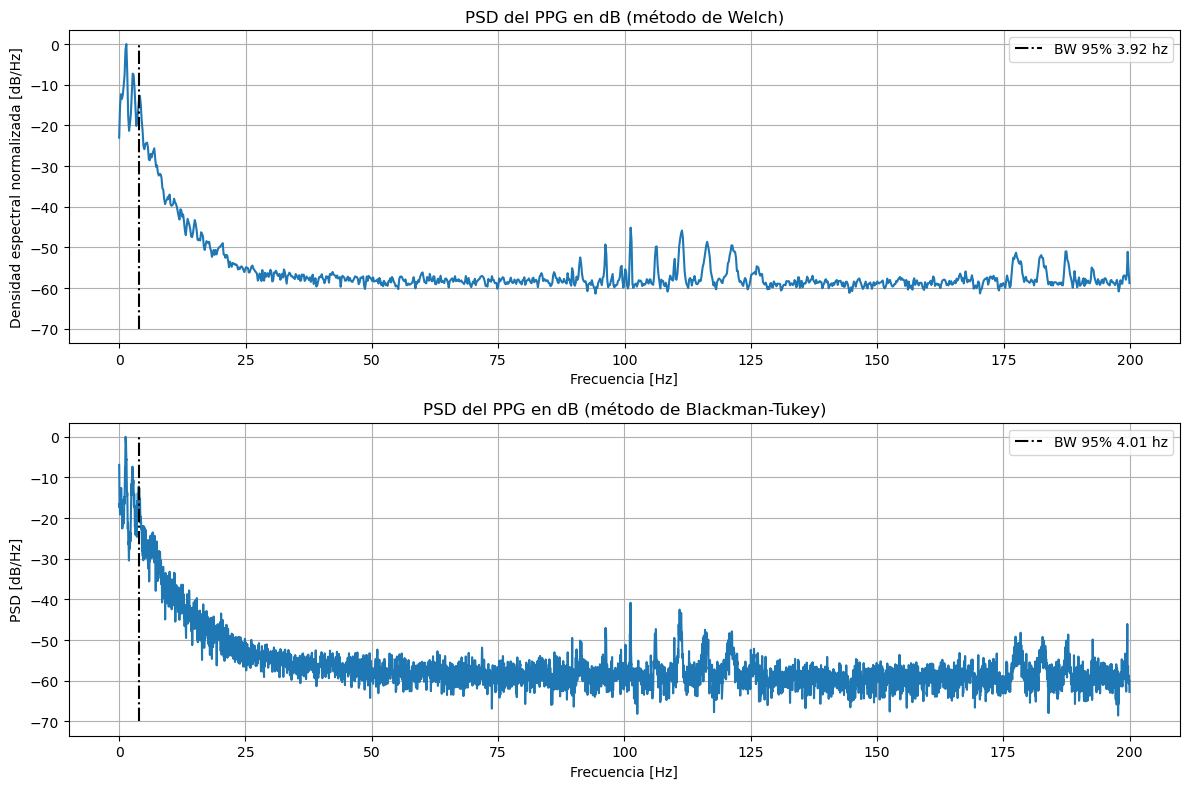

In [14]:
##Lectura##
fs_ppg = 400 # Hz, la frecuencia de muestreo a la que fue sampleada la señal del archivo
ppg = np.load('ppg_sin_ruido.npy')
N_ppg = len(ppg)

##Welch##
nperseg = N_ppg // 20  #cantidad de segmentos
noverlap = nperseg//2 #solapamiento
f_ppg, PSD_ppg = sig.welch(ppg, fs_ppg, window='hamming',
                    nperseg=nperseg, noverlap=noverlap, detrend= 'linear')
PSD_ppg_db = 10 * np.log10(PSD_ppg) #Paso a dB
PSD_ppg_db_norm = PSD_ppg_db - np.max(PSD_ppg_db) #Normalizo respecto al máximo (pico en 0 dB)

##Blackman-Tukey##
f_ppg_bt, PSD_bt, PSD_db_bt = blackman_tukey(ppg, fs=fs_ppg) #Blackman-Tukey
PSD_db_bt_norm = PSD_db_bt - np.max(PSD_db_bt) #Normalizo respecto al máximo (pico en 0 dB)

##Estimación ancho de banda Welch##
porcentaje = 0.95
pot_total_welch =np.sum(PSD_ppg)
pot_acumulada_welch = np.cumsum(PSD_ppg) / pot_total_welch  # ahora ya es proporción
i = np.argmax(pot_acumulada_welch >= porcentaje)  # primer índice que supera el %
frec_buscada_welch = f_ppg[i]

##Estimación ancho de banda B-T##
pot_total_bt = np.sum(PSD_bt)
pot_acumulada_bt = np.cumsum(PSD_bt) / pot_total_bt  # ahora ya es proporción
i = np.argmax(pot_acumulada_bt >= porcentaje)  # primer índice que supera el %
frec_buscada_bt = f_ppg_bt[i]

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(f_ppg, PSD_ppg_db_norm)
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Densidad espectral normalizada [dB/Hz]')
plt.title('PSD del PPG en dB (método de Welch)')
plt.vlines(x=frec_buscada_welch,ymin=-70,ymax=0,colors='black',linestyles='dashdot',label=f'BW {porcentaje *100:.0f}% {frec_buscada_welch:.2f} hz')
plt.legend()
plt.tight_layout()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(f_ppg_bt, PSD_db_bt_norm)
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB/Hz]')
plt.title('PSD del PPG en dB (método de Blackman-Tukey)')
plt.vlines(x=frec_buscada_bt,ymin=-70,ymax=0,colors='black',linestyles='dashdot',label=f'BW {porcentaje *100:.0f}% {frec_buscada_bt:.2f} hz')
plt.legend()
plt.tight_layout()
plt.grid(True)

#### Audio:

En estas señales contamos con 144.000 muestras se realizaron 50 particiones siempre cuidando la relación sesgo/varianza, de esta forma contamos con 2880 muestras por bloque.

A diferencia de las señales fisiológicas, el audio analizado proviene de una fuente controlada, lo que se traduce en un contenido espectral más limpio, con componentes bien definidas en frecuencia y escaso ruido de fondo. Esto se refleja en estimaciones espectrales con lóbulos bien delimitados y una mayor concentración de energía en bandas estrechas.

Estas características hacen que el análisis espectral sea más claro y la estimación del ancho de banda más precisa, ya que no se ve afectada por variaciones biológicas impredecibles ni por artefactos asociados al registro.

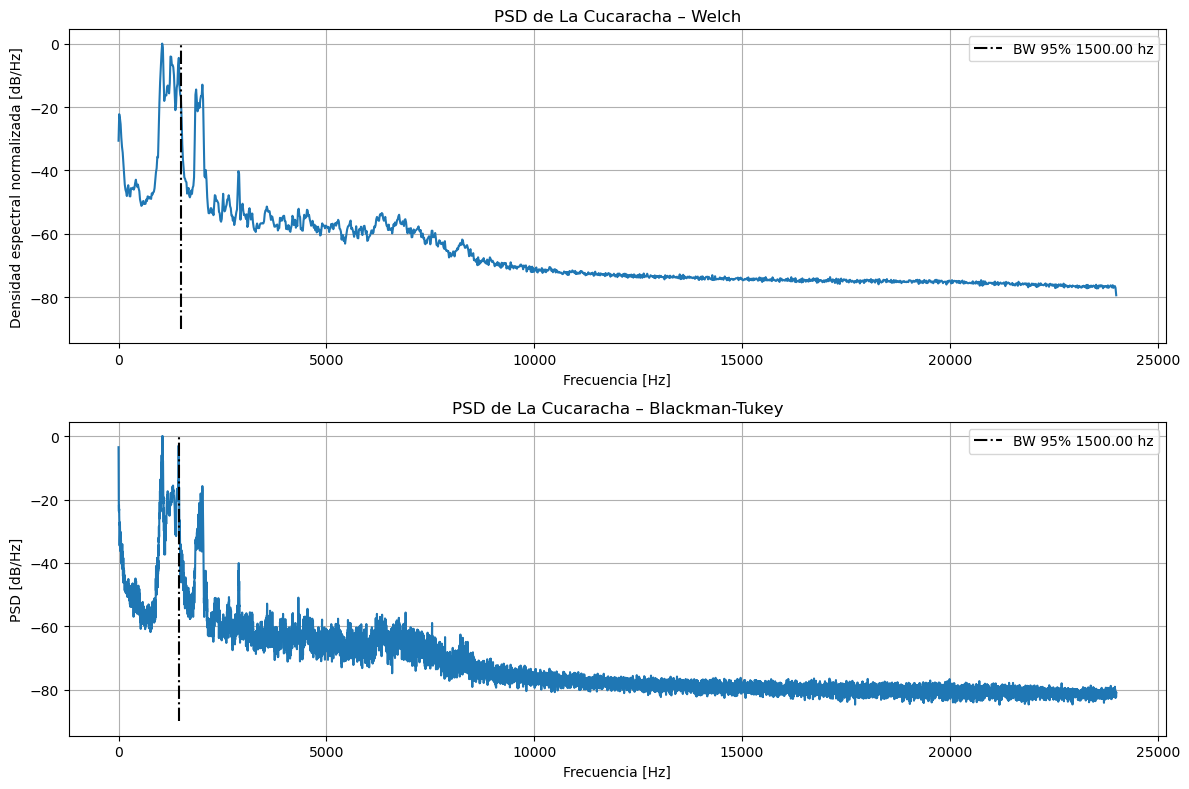

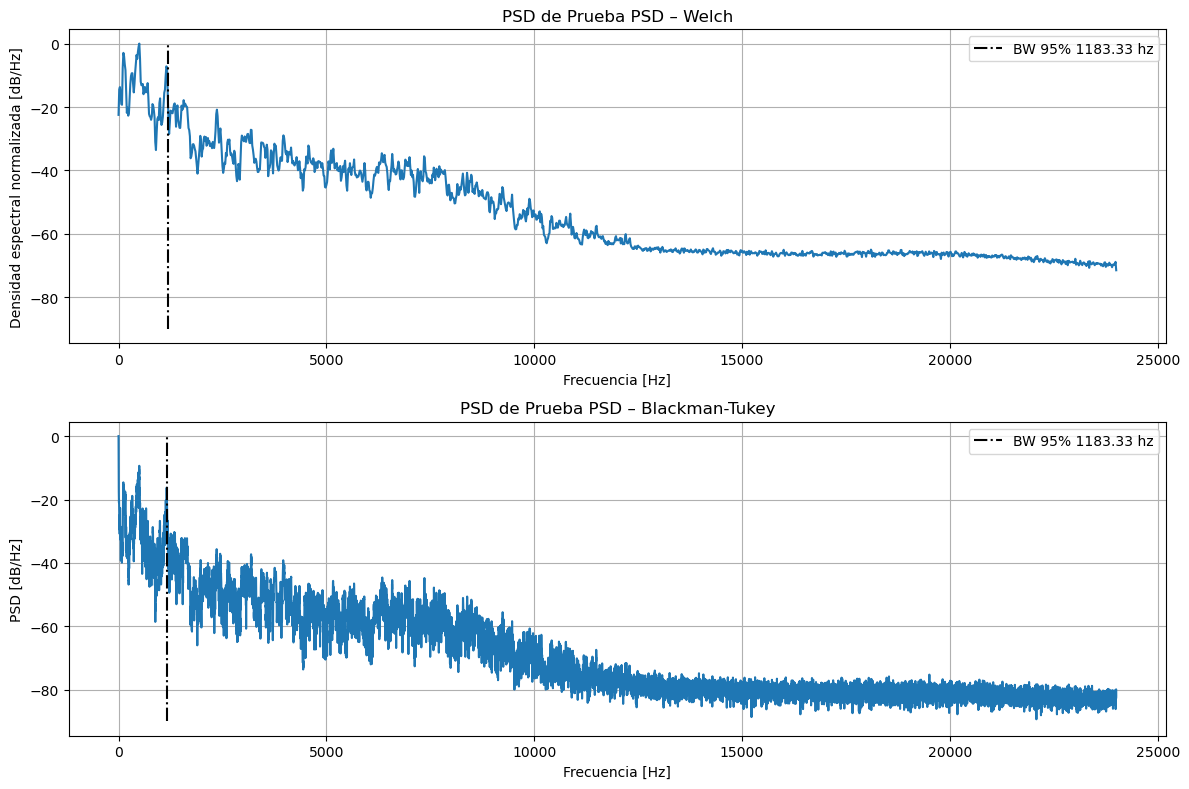

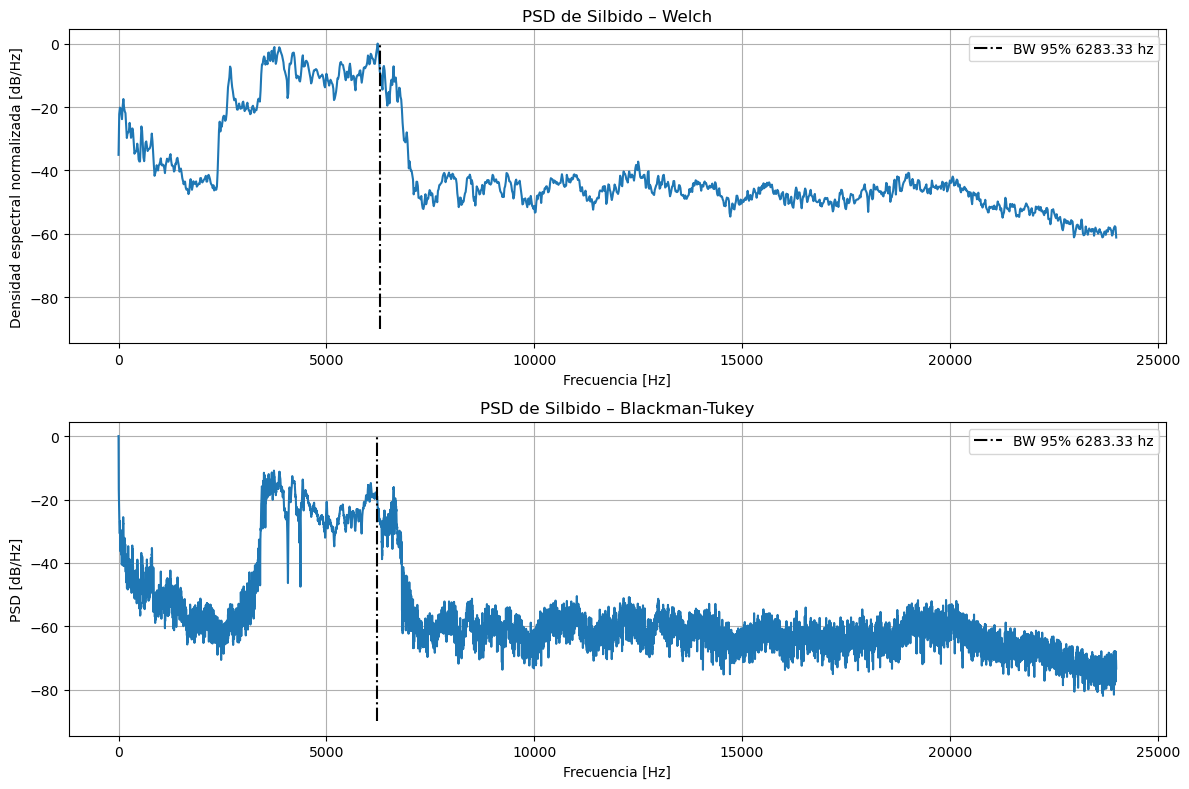

In [12]:
#%%#################
# Lectura de audio #
####################
# Archivos de audio a procesar
archivos = ['la cucaracha.wav', 'prueba psd.wav', 'silbido.wav']
titulos = ['La Cucaracha', 'Prueba PSD', 'Silbido']

for j, archivo in enumerate(archivos):
    fs, x = sio.wavfile.read(archivo) # Carga de señal
    x = x.astype(np.float64)
    ##Lectura##
    fs_audio, wav_data = sio.wavfile.read(archivo) #esta funciòn devuelve la fs
    N_audio = len(wav_data)
    
    ##Welch##
    nperseg = N_audio // 50  #cantidad de segmentos
    noverlap = nperseg//2 #solapamiento
    f_audio, PSD_audio = sig.welch(wav_data, fs_audio, window='hamming',
                        nperseg=nperseg, noverlap=noverlap)
    PSD_audio_db = 10 * np.log10(PSD_audio) #Paso a dB
    PSD_audio_db_norm = PSD_audio_db - np.max(PSD_audio_db) #Normalizo respecto al máximo (pico en 0 dB)
    
    ##Blackman-Tukey##
    f_bt_audio, PSD_bt, PSD_db_bt = blackman_tukey(wav_data, fs=fs_audio)
    PSD_db_bt_norm = PSD_db_bt - np.max(PSD_db_bt) #Normalizo respecto al máximo (pico en 0 dB)
    
    ##Estimación ancho de banda Welch##
    porcentaje = 0.95
    pot_total_welch =np.sum(PSD_audio)
    pot_acumulada_welch = np.cumsum(PSD_audio) / pot_total_welch  # ahora ya es proporción
    i = np.argmax(pot_acumulada_welch >= porcentaje)  # primer índice que supera el %
    frec_buscada_welch = f_audio[i]
    
    ##Estimación ancho de banda B-T##
    pot_total_bt = np.sum(PSD_bt)
    pot_acumulada_bt = np.cumsum(PSD_bt) / pot_total_bt  # ahora ya es proporción
    i = np.argmax(pot_acumulada_bt >= porcentaje)  # primer índice que supera el %
    frec_buscada_bt = f_bt_audio[i]
    
    ##Visualización##
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(f_audio, PSD_audio_db_norm)
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Densidad espectral normalizada [dB/Hz]')
    plt.title(f'PSD de {titulos[j]} – Welch')
    plt.vlines(x=frec_buscada_welch,ymin=-90,ymax=0,colors='black',linestyles='dashdot',label=f'BW {porcentaje *100:.0f}% {frec_buscada_welch:.2f} hz')
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    plt.plot(f_bt_audio, PSD_db_bt_norm)
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('PSD [dB/Hz]')
    #plt.title('PSD del audio en dB (método de Blackman-Tukey)')
    plt.title(f'PSD de {titulos[j]} – Blackman-Tukey')
    plt.vlines(x=frec_buscada_bt,ymin=-90,ymax=0,colors='black',linestyles='dashdot',label=f'BW {porcentaje *100:.0f}% {frec_buscada_welch:.2f} hz')
    plt.legend()
    plt.tight_layout()
    plt.grid(True)



## Consigna 2

A continuación se presentan los anchos de banda estimados para cada señal utilizando dos métodos distintos de estimación espectral. El BW representa la frecuencia hasta la cual se acumula el 98% o el 95% de la potencia total:

$\textbf{Tabla 1: Resultados Welch}$
\
\begin{array}{|c|c|c|c|c|}
\hline
\textbf{Señal} & \textbf{BW 98% [hz] } & \textbf{BW 95% [hz]} \\
\hline
\text{ECG} & 27,33 & 22,67 \\
\text{PPG} & 4,45 & 3,92 \\
\text{La cucaracha} & 1.983,33 & 1.500 \\
\text{Prueba PSD} & 1.633,33 & 1.183.33 \\
\text{Silbido} & 6.583,33 & 6.283,33 \\
\hline
\end{array}
$\\[2em]$ 

$\textbf{Tabla 2: Resultados Blackman-Tukey}$
\
\begin{array}{|c|c|c|c|c|}
\hline
\textbf{Señal} & \textbf{BW 98% [hz]} & \textbf{BW 95% [hz]} \\
\hline
\text{ECG} & 27,60 & 23,13 \\
\text{PPG} & 5,34 & 4,01 \\
\text{La cucaracha} & 1.983,33 & 1.500 \\
\text{Prueba PSD} & 1.633,33 & 1.183,33 \\
\text{Silbido} & 6.583,33 & 6.283,33 \\
\hline
\end{array}
$\\[2em]$ 

# Análisis de resultados

Los anchos de banda estimados muestran diferencias significativas entre las señales fisiológicas (ECG y PPG) y las señales de audio. Las señales fisiológicas presentan un contenido espectral más concentrado en bajas frecuencias, con anchos de banda menores a 30 Hz, lo cual es consistente con la naturaleza de los procesos biológicos lentos que representan.

En cambio, las señales de audio exhiben anchos de banda mucho mayores, con componentes espectrales bien definidas y distribuidas en una porción más amplia del espectro, llegando hasta varios kilohertz. Este contraste es esperable dado que el audio proviene de fenómenos controlados (voz y silbidos) que contienen información de alta frecuencia.

Al comparar los métodos, se observa que Welch y Blackman-Tukey entregan estimaciones muy similares en todos los casos, especialmente en señales limpias como el audio. En señales fisiológicas, donde el contenido espectral es más difuso, las diferencias entre el BW al 95% y al 98% son más marcadas, lo que evidencia la distribución más gradual de la energía.


#  💎 Bonus 
### Comparación antes y después del filtrado

Inicialmente, las señales de ECG y PPG que se procesaron no habían sido filtradas digitalmente, lo que introducía un nivel considerable de ruido y componentes espurias en las estimaciones espectrales. Esto dificultaba la determinación precisa del ancho de banda.

Posteriormente, se trabajo con un nuevo conjunto de datos en el que ambas señales ya habían sido prefiltradas. A continuación se muestra las comparativas de los resultados obtenidos para las señales fisiológicas **antes y después del filtrado**. 

A continuación se grafica las señales en el tiempo antes y después de la aplicación de las técnicas de mitigación de ruido, donde se puede observar como el filtrado logra remover la tendencia de fondo, centrando la señal en torno a un valor medio nulo, y eliminar la modulación en baja frecuencia (posiblemente influencia respiratoria):

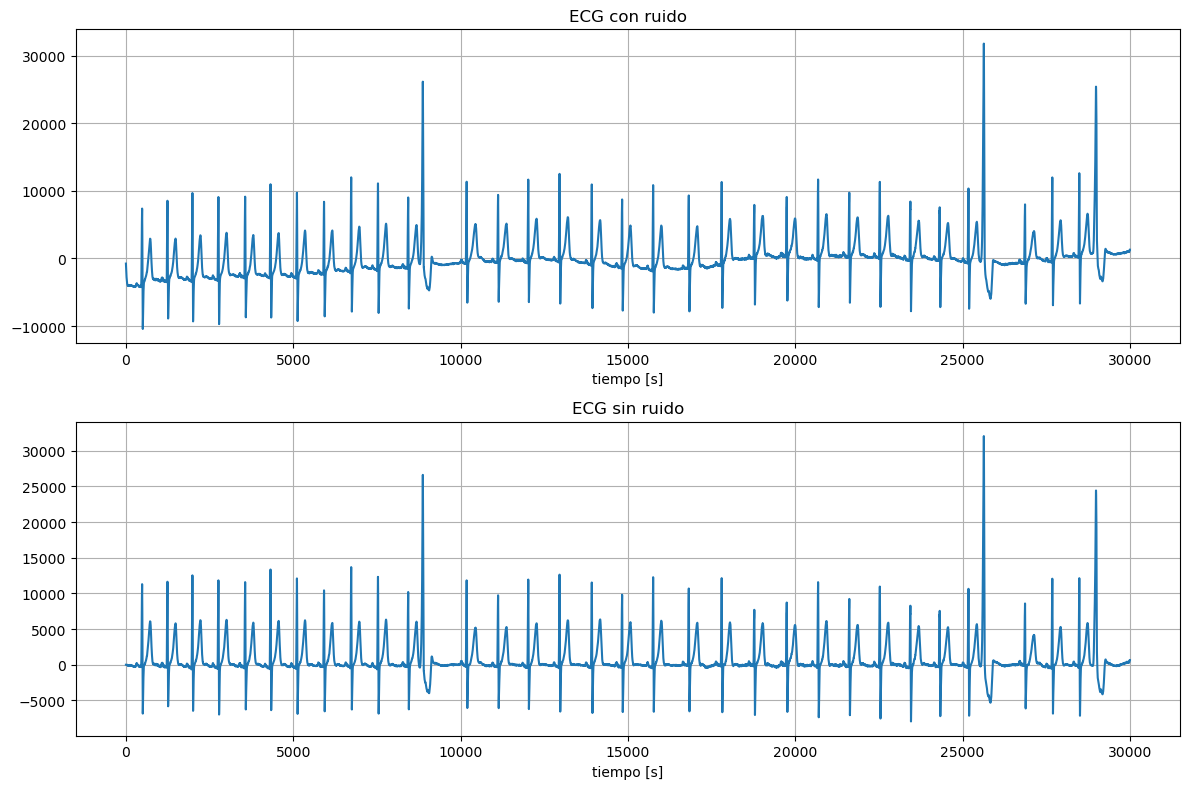

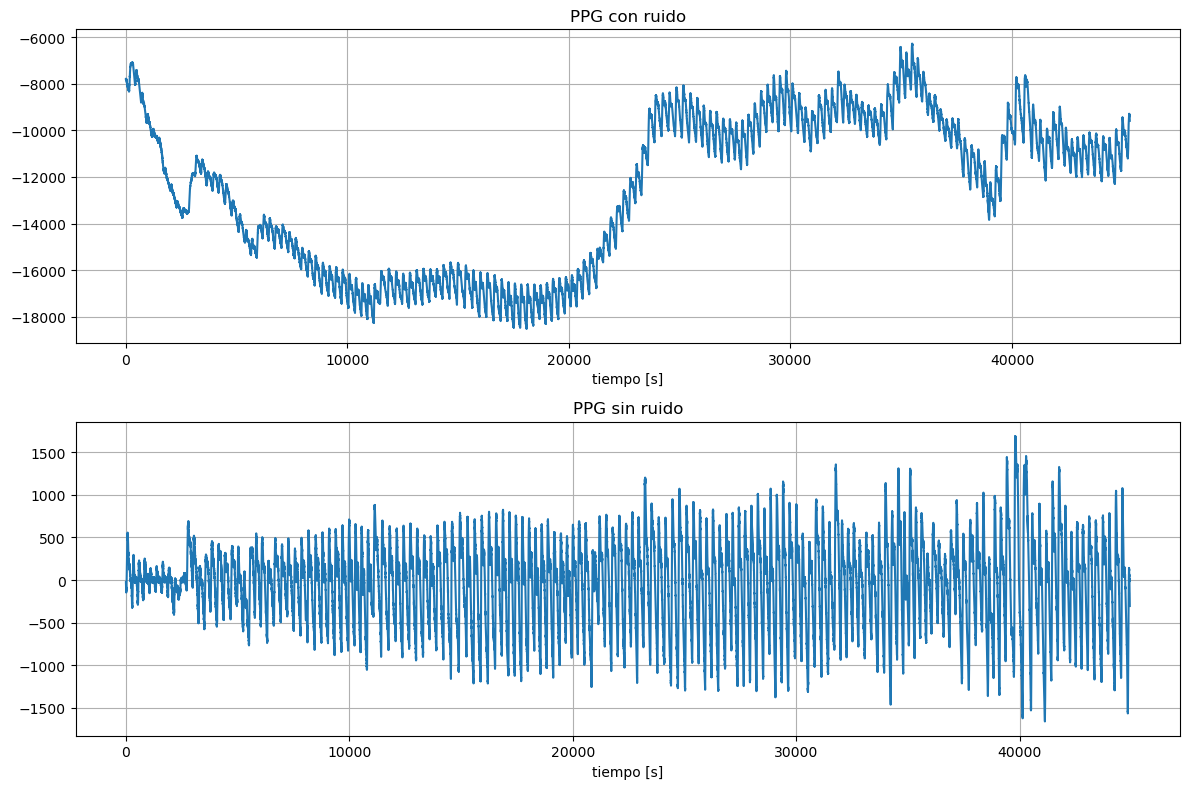

In [17]:
mat_struct = sio.loadmat('./ECG_TP4.mat') 
ecg_con_ruido = mat_struct['ecg_lead'].flatten() 
ecg_con_ruido = ecg_con_ruido[:30000]
ecg_sin_ruido = np.load('ecg_sin_ruido.npy')

plt.figure(figsize=(12, 8))

plt.subplot(2,1,1)
plt.plot(ecg_con_ruido)
plt.xlabel('tiempo [s]')
plt.title('ECG con ruido')
plt.grid(True)
plt.tight_layout()

plt.subplot(2,1,2)
plt.plot(ecg_sin_ruido)
plt.xlabel('tiempo [s]')
plt.title('ECG sin ruido')
plt.grid(True)
plt.tight_layout()

ppg_con_ruido = np.genfromtxt('PPG.csv', delimiter=',', skip_header=1)
ppg_sin_ruido = np.load('ppg_sin_ruido.npy')

plt.figure(figsize=(12, 8))

plt.subplot(2,1,1)
plt.plot(ppg_con_ruido)
plt.xlabel('tiempo [s]')
plt.title('PPG con ruido')
plt.grid(True)
plt.tight_layout()

plt.subplot(2,1,2)
plt.plot(ppg_sin_ruido)
plt.xlabel('tiempo [s]')
plt.title('PPG sin ruido')
plt.grid(True)
plt.tight_layout()

En la siguientes tablas se presentan los resultados antes y después de la mitigación del ruido:

$\textbf{Tabla 3: Resultados CON prefiltrado}$
\
\begin{array}{|c|c|c|c|c|}
\hline
\textbf{Señal} & \textbf{Welch BW 98\% [Hz]} & \textbf{Welch BW 95\% [Hz]} & \textbf{B-T BW 98\% [Hz]} & \textbf{B-T BW 95\% [Hz]} \\
\hline
\text{ECG} & 27{,}33 & 22{,}67 & \text{27,60} & \text{23,13} \\
\text{PPG} & 4{,}45 & 3{,}92 & \text{5,34} & \text{4,01} \\
\hline
\end{array}
$\\[2em]$ 
$\textbf{Tabla : Resultados SIN prefiltrado}$
\
\begin{array}{|c|c|c|c|c|}
\hline
\textbf{Señal} & \textbf{Welch BW 98\% [Hz]} & \textbf{Welch BW 95\% [Hz]} & \textbf{B-T BW 98\% [Hz]} & \textbf{B-T BW 95\% [Hz]} \\
\hline
\text{ECG} & 28{,}33 & 25 & \text{26,42} & \text{21,67} \\
\text{PPG} & 4{,}24 & 3{,}53 & \text{0,09} & \text{0,05} \\
\hline
\end{array}


### Comparación de resultados antes y después del prefiltrado

Teóricamente, cuando se elimina ruido de una señal —especialmente ruido blanco o de alta frecuencia— se espera que el ancho de banda estimado disminuya. Esto se debe a que el ruido introduce energía distribuida en todo el espectro, expandiendo artificialmente la banda necesaria para acumular una fracción significativa (95%, 98%) de la potencia total.

Sin embargo esta expectativa teórica solo explica los resultados del ECG para el método de Welch. Para todos los demás casos vemos que aumentan los anchos de banda luego de filtrar la señal. 

El caso más llamativo es el método de Blackman-Tukey en la señal PPG. Contrario a lo anticipado, el ancho de banda estimado **aumenta** significativamente luego del filtrado, pasando de valores mínimos (0,09 Hz para BW98%) a una banda mucho más amplia (5,34 Hz).

Este resultado desafía la expectativa inicial y abre algunos interrogantes. Una posible explicación es que la señal sin filtrar presenta tal nivel de ruido que su auto-correlación se degrada, llevando a una PSD que concentra energía en torno al cero frecuencial. En cambio, el filtrado habría permitido recuperar componentes reales de la señal, visibles ahora en la auto-correlación, expandiendo así el BW de manera más representativa.

No obstante, también cabe la posibilidad de que el valor tan bajo de BW en la señal sin filtrar sea el producto de una estimación defectuosa o mal resuelta por el método de Blackman-Tukey, dada su sensibilidad a la elección de la ventana y a la estructura estadística del ruido.

Mas allá de estas posibles explicaciones me queda la inquietud para discutirla en clase.

Pero en definitiva, este análisis subraya la importancia de interpretar con cautela las estimaciones espectrales cuando se trata de señales muy ruidosas y de contrastar los resultados con diferentes métodos antes de extraer conclusiones definitivas. 

# Conclusión final

A lo largo de este trabajo se aplicaron distintos métodos de estimación espectral para analizar señales reales de diversa naturaleza. Los métodos de Welch y Blackman-Tukey demostraron ser herramientas robustas para caracterizar el contenido espectral de señales tanto fisiológicas como artificiales.

Las señales fisiológicas (ECG y PPG) presentaron espectros más difusos y de bajo ancho de banda, reflejando la lentitud y variabilidad de los procesos biológicos. En contraste, las señales de audio mostraron componentes espectrales nítidas y distribuidas en frecuencias significativamente más altas, lo que permitió validar y contrastar los métodos en un escenario más definido.

La estrategia de normalizar los espectros respecto al valor máximo (0 dB) resultó efectiva para comparar señales con anchos de banda muy distintos, preservando las formas relativas sin necesidad de imponer una escala absoluta de potencia.

En conjunto, el análisis evidenció cómo la naturaleza de la señal influye en el resultado espectral y cómo la elección del método, el tamaño de la ventana y la forma de normalización impactan sobre la interpretación final. El trabajo proporciona un marco sólido para abordar análisis espectral en contextos reales y diversos.
